# Phase 4 project - Nate EDA - Word Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import nltk
from nltk import pos_tag
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

%matplotlib inline

Read in the data set and review the data

In [3]:
data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

In [4]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# Change the column names so it can be more readable

data.columns = ['tweet', 'product', 'sentiment']

In [6]:
data.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [7]:
data.sentiment.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [8]:
df = data[(data['sentiment'] == "Negative emotion") | (data['sentiment'] == "Positive emotion")]

In [9]:
df = data.dropna(axis=0)

In [10]:
df

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion


In [11]:
df['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

In [12]:
df.isnull().sum()

tweet        0
product      0
sentiment    0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3291 entries, 0 to 9088
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      3291 non-null   object
 1   product    3291 non-null   object
 2   sentiment  3291 non-null   object
dtypes: object(3)
memory usage: 102.8+ KB


Pre-processing

In [15]:
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [16]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [17]:
df

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion


<ipython-input-24-90c1795ea903>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet_edited'] = df['tweet']
<ipython-input-24-90c1795ea903>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet_edited'] = df['tweet_edited'].apply(str.lower)
<ipython-input-24-90c1795ea903>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

,tweet,product,sentiment,tweet_edited,Company
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,g iphone hr tweeting rise austin dead need upg...,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate...,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad also sale sxsw,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year's festival crashy year's iphone app ...,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer google tim ...,Google
...,...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,pr guy convince switch back iphone great sxsw ...,Apple
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,papyrus sort like ipad nice lol sxsw lavelle,Apple
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion,diller say google tv might run playstation xbo...,Google
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,i've always use camera iphone b c image stabil...,Apple


Look into the top words from Negative iPhone tweets

<ipython-input-25-80c3431da36b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['tweet_edited'] = df_subset['tweet_edited'].str.split()
C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Words in Positive Apple Tweets')

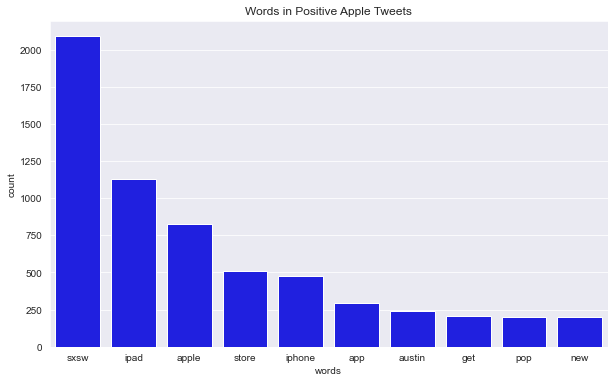

In [25]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)
lemmatizer = nltk.stem.WordNetLemmatizer()
sw = set(stopwords.words('english'))
sw.update(['link', 'rt', 'quot', 'amp'])

df['tweet_edited'] = df['tweet']
df['tweet_edited'] = df['tweet_edited'].apply(str.lower)
df['tweet_edited'] = df['tweet_edited'].apply(str.split)
df['tweet_edited'] = df['tweet_edited'].apply(lambda x: " ".join([n for n in x if '@' not in n]))
df['tweet_edited'] = df['tweet_edited'].apply(tokenizer.tokenize)
df['tweet_edited'] = df['tweet_edited'].apply(pos_tag)
df['tweet_edited'] = df['tweet_edited'].apply(lambda x: [(n[0], get_wordnet_pos(n[1])) for n in x])
df['tweet_edited'] = df['tweet_edited'].apply(lambda x: " ".join([lemmatizer.lemmatize(n[0], (n[1])) for n in x]))
df['tweet_edited'] = df['tweet_edited'].apply(lambda x: " ".join([n for n in x.split() if n not in sw]))

df['product'] = df['product'].apply(str.strip)
df['Company'] = df['product']
df['Company'] = df['Company'].replace({
    'iPad':'Apple',
    'iPad or iPhone App':'Apple',
    'iPhone':'Apple',
    'Other Apple product or service':'Apple',
    'Other Google product or service':'Google',
    'Android App':'Google',
    'Android':'Google'   
})
df

import seaborn as sns
df_subset = df[(df['Company']=='Apple') & (df['sentiment']=='Positive emotion')]
df_subset['tweet_edited'] = df_subset['tweet_edited'].str.split()
df_subset = df_subset.tweet_edited.explode()
df_subset

sns.set_style("darkgrid")

graphinfo = df_subset.value_counts()[0:10]
fix, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(graphinfo.index, graphinfo, ax = ax, color='blue')
ax.set_ylabel("count")
ax.set_xlabel('words')
ax.set_title('Words in Positive Apple Tweets')

Look into the top words from Negative iPhone tweets

<ipython-input-29-1a6c6628469c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet_edited'] = df['tweet']
<ipython-input-29-1a6c6628469c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet_edited'] = df['tweet_edited'].apply(str.lower)
<ipython-input-29-1a6c6628469c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

Text(0.5, 1.0, 'Words in Negative iPhone Tweets')

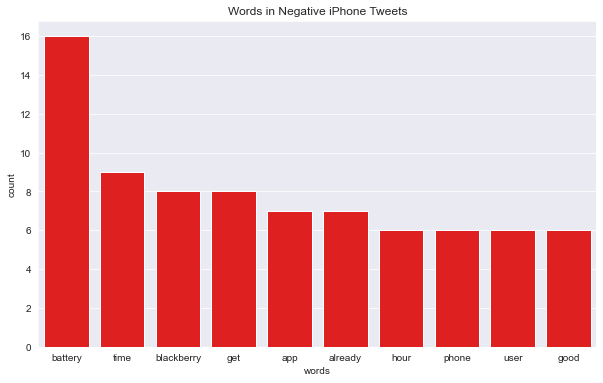

In [29]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)
lemmatizer = nltk.stem.WordNetLemmatizer()
sw = set(stopwords.words('english'))
sw.update(['link', 'rt', 'quot', 'amp', 'iphone', 'sxsw', 'go', 'g', 'austin'])

df['tweet_edited'] = df['tweet']
df['tweet_edited'] = df['tweet_edited'].apply(str.lower)
df['tweet_edited'] = df['tweet_edited'].apply(str.split)
df['tweet_edited'] = df['tweet_edited'].apply(lambda x: " ".join([n for n in x if '@' not in n]))
df['tweet_edited'] = df['tweet_edited'].apply(tokenizer.tokenize)
df['tweet_edited'] = df['tweet_edited'].apply(pos_tag)
df['tweet_edited'] = df['tweet_edited'].apply(lambda x: [(n[0], get_wordnet_pos(n[1])) for n in x])
df['tweet_edited'] = df['tweet_edited'].apply(lambda x: " ".join([lemmatizer.lemmatize(n[0], (n[1])) for n in x]))
df['tweet_edited'] = df['tweet_edited'].apply(lambda x: " ".join([n for n in x.split() if n not in sw]))

df['product'] = df['product'].apply(str.strip)
df['Company'] = df['product']
df['Company'] = df['Company'].replace({
    'iPad':'Apple',
    'iPad or iPhone App':'Apple',
    'iPhone':'Apple',
    'Other Apple product or service':'Apple',
    'Other Google product or service':'Google',
    'Android App':'Google',
    'Android':'Google'   
})

import seaborn as sns
df_subset = df[(df['Company']=='Apple') & (df['sentiment']=='Negative emotion')  & (df['product']=='iPhone')]
df_subset['tweet_edited'] = df_subset['tweet_edited'].str.split()
df_subset = df_subset.tweet_edited.explode()
df_subset


graphinfo = df_subset.value_counts()[0:10]
fix, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(graphinfo.index, graphinfo, ax = ax, color='red')
ax.set_ylabel("count")
ax.set_xlabel('words')
ax.set_title('Words in Negative iPhone Tweets')
